### 神经网络模型
可自定义隐藏层大小、激活函数

In [137]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, lambda_reg, activation):
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.activation = activation
        self.lambda_reg = lambda_reg

        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size_1)  # 输入到第一层
        self.b1 = np.zeros((1, hidden_size_1))
        self.W2 = np.random.randn(hidden_size_1, hidden_size_2)  # 第一层到第二层
        self.b2 = np.zeros((1, hidden_size_2))
        self.W3 = np.random.randn(hidden_size_2, output_size)  # 第二层到输出层
        self.b3 = np.zeros((1, output_size))

    def softmax(self,x):
        # 避免指数爆炸，减去最大值
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)
    
    def forward(self, X):
        # Forward propagation
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activation(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.activation(self.z3)
        return self.a3

    def backward(self, X, y, lr):
        m = X.shape[0]
        # Backpropagation
        dZ3 = self.a3 - y
        dW3 = (1 / m) * np.dot(self.a2.T, dZ3)
        db3 = (1 / m) * np.sum(dZ3, axis=0, keepdims=True)
        dZ2 = np.dot(dZ3, self.W3.T) * self.activation_derivative(self.a2)
        dW2 = (1 / m) * np.dot(self.a1.T, dZ2)
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * self.activation_derivative(self.a1)
        dW1 = (1 / m) * np.dot(X.T, dZ1)
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
        
        # Update weights and biases using gradients(L2正则化)
        self.W1 -= lr * (dW1+self.lambda_reg*self.W1) 
        self.b1 -= lr * db1
        self.W2 -= lr * (dW2+self.lambda_reg*self.W2)
        self.b2 -= lr * db2
        self.W3 -= lr * (dW3+self.lambda_reg*self.W3)
        self.b3 -= lr * db3

    def set_activation(self, activation):
        self.activation = activation

    def activation_derivative(self, x):   #求导
        # Derivative of the activation function
        if self.activation == sigmoid:
            return x * (1 - x)
        elif self.activation == relu:
            return np.where(x > 0, 1, 0)
        elif self.activation == tanh:
            return 1 - x**2
        else:
            raise ValueError("Unsupported activation function")

# Define custom activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

### 训练部分
计算交叉熵损失以及L2正则化，实现小批量SGD，每轮训练学习率下降为原本的97%

根据验证集上的准确度得分保存最优模型参数

In [138]:
import matplotlib.pyplot as plt
def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    loss = -1 / m * np.sum(y_true * np.log(y_pred + 1e-15))
    return loss

def l2_regularization(W1, W2, W3, lambda_reg, m):
    reg_loss = (lambda_reg / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    return reg_loss


def train(X_train, y_train, X_val, y_val, input_size, hidden_size_1, hidden_size_2, output_size, epochs, lr, lambda_reg, act_func):
    nn = NeuralNetwork(input_size, hidden_size_1, hidden_size_2, output_size,lambda_reg,act_func)
    best_val_accuracy = 0
    best_weights = None
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    m = X_train.shape[0]  # Number of training examples

    def plot_training_history(history):
        epochs = len(history['train_loss'])
        x_ticks = range(5, epochs + 1, 5)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), history['train_loss'], label='Train Loss')
        plt.plot(range(1, epochs + 1), history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.xticks(x_ticks)

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), history['val_accuracy'], label='Val Accuracy', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.xticks(x_ticks)

        plt.tight_layout()
        plt.show()
    for epoch in range(epochs):
        # Shuffle the training data for each epoch
        shuffled_indices = np.random.permutation(m)
        X_train_shuffled = X_train[shuffled_indices]
        y_train_shuffled = y_train[shuffled_indices]
        batch_size=600
        # Mini-batch SGD
        for i in range(0, m, batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            # Forward and backward pass on mini-batch
            y_pred_batch = nn.forward(X_batch)
            train_loss = cross_entropy_loss(y_pred_batch, y_batch)
            reg_loss = l2_regularization(nn.W1, nn.W2, nn.W3, lambda_reg, X_batch.shape[0])
            total_loss = train_loss + reg_loss
            nn.backward(X_batch, y_batch, lr)

        # Forward pass on validation set
        y_pred_val = nn.forward(X_val)
        val_loss = cross_entropy_loss(y_pred_val, y_val)
        val_accuracy = np.mean(np.argmax(y_val, axis=1) == np.argmax(y_pred_val, axis=1))

        # Save best weights based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_weights = {'W1': nn.W1, 'b1': nn.b1, 'W2': nn.W2, 'b2': nn.b2, 'W3': nn.W3, 'b3': nn.b3}

        # Print progress
        if (epoch+1)%5==0:
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        # Update history(可视化1)
        history['train_loss'].append(total_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # Learning rate decay
        lr *= 0.97
    plot_training_history(history)
    return best_weights, best_val_accuracy


### 训练（参数查找）
针对学习率、L2正则化系数以及隐藏层大小进行网格搜索

In [139]:
def grid_search(X_train, y_train, X_val, y_val, input_size, output_size, epoch, lr_range, lambda_reg_range, hidden_sizes,act_func):
    best_val_accuracy = 0
    best_hyperparams = {}   #最优超参数组合
    best_weights={}
    all_result=[]
    for hidden_size_1,hidden_size_2 in hidden_sizes:  #隐藏层大小
            print('隐藏层大小为：'+str((hidden_size_1,hidden_size_2)))
            for lr in lr_range:  #学习率
                for lambda_reg in lambda_reg_range:  #正则化参数
                    print('学习率：'+str(lr),'正则化强度'+str(lambda_reg))
                    # Train model with current hyperparameters
                    best_weights_cur, best_accuracy = train(X_train, y_train, X_val, y_val, input_size, hidden_size_1, hidden_size_2, output_size, epoch, lr, lambda_reg,act_func)
                    
                    # Evaluate model on validation set
                    val_accuracy = best_accuracy

                    # Check if current model is better
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_hyperparams = {
                            'hidden_size_1': hidden_size_1,
                            'hidden_size_2': hidden_size_2,
                            'lr': lr,
                            'lambda_reg': lambda_reg
                        }
                        best_weights=best_weights_cur
                    all_result.append({
                            'hidden_size_1': hidden_size_1,
                            'hidden_size_2': hidden_size_2,
                            'lr': lr,
                            'lambda_reg': lambda_reg,
                            'val_accuracy':val_accuracy
                        })  
    return best_hyperparams,best_val_accuracy,best_weights


### 调用网格搜索函数进行训练模型及参数查找

隐藏层大小为：(256, 64)
学习率：0.01 正则化强度0.01


C:\Users\bwr\AppData\Local\Temp\ipykernel_39244\3079578162.py:75: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 5: Train Loss: 2.3993 | Val Loss: 2.3704 | Val Accuracy: 0.2697
Epoch 10: Train Loss: 1.7945 | Val Loss: 1.8924 | Val Accuracy: 0.3938
Epoch 15: Train Loss: 1.6933 | Val Loss: 1.6930 | Val Accuracy: 0.4557
Epoch 20: Train Loss: 1.4801 | Val Loss: 1.5725 | Val Accuracy: 0.4937
Epoch 25: Train Loss: 1.4738 | Val Loss: 1.4931 | Val Accuracy: 0.5193


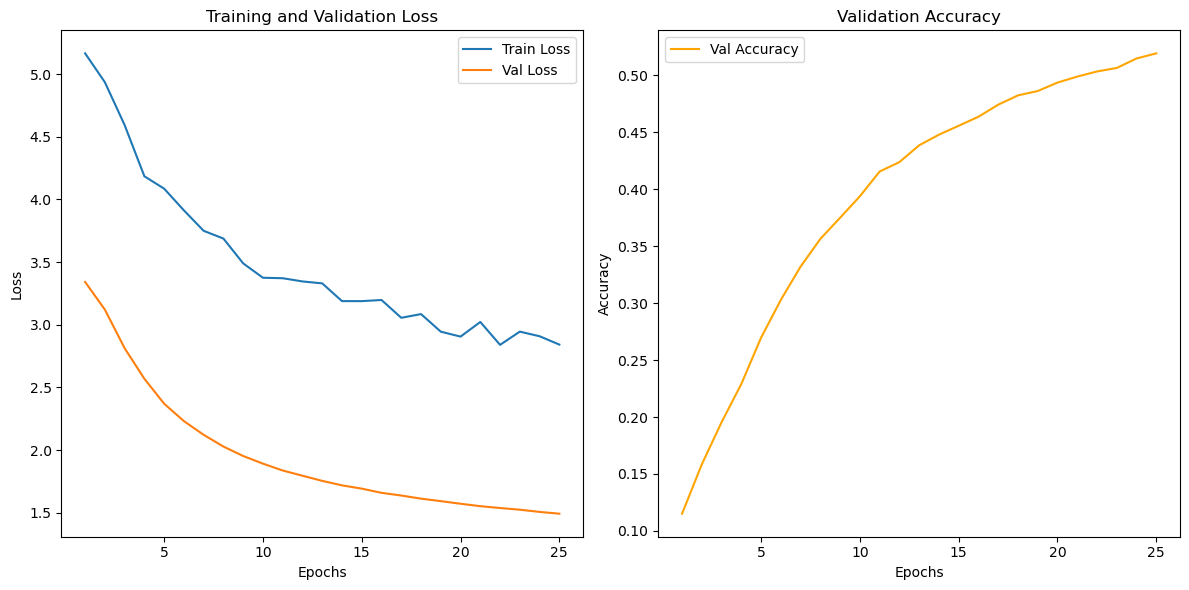

学习率：0.01 正则化强度0.1
Epoch 5: Train Loss: 2.0207 | Val Loss: 1.9619 | Val Accuracy: 0.3339
Epoch 10: Train Loss: 1.6451 | Val Loss: 1.6165 | Val Accuracy: 0.4801
Epoch 15: Train Loss: 1.4787 | Val Loss: 1.5158 | Val Accuracy: 0.5616
Epoch 20: Train Loss: 1.4508 | Val Loss: 1.4824 | Val Accuracy: 0.6043
Epoch 25: Train Loss: 1.4697 | Val Loss: 1.4744 | Val Accuracy: 0.6329


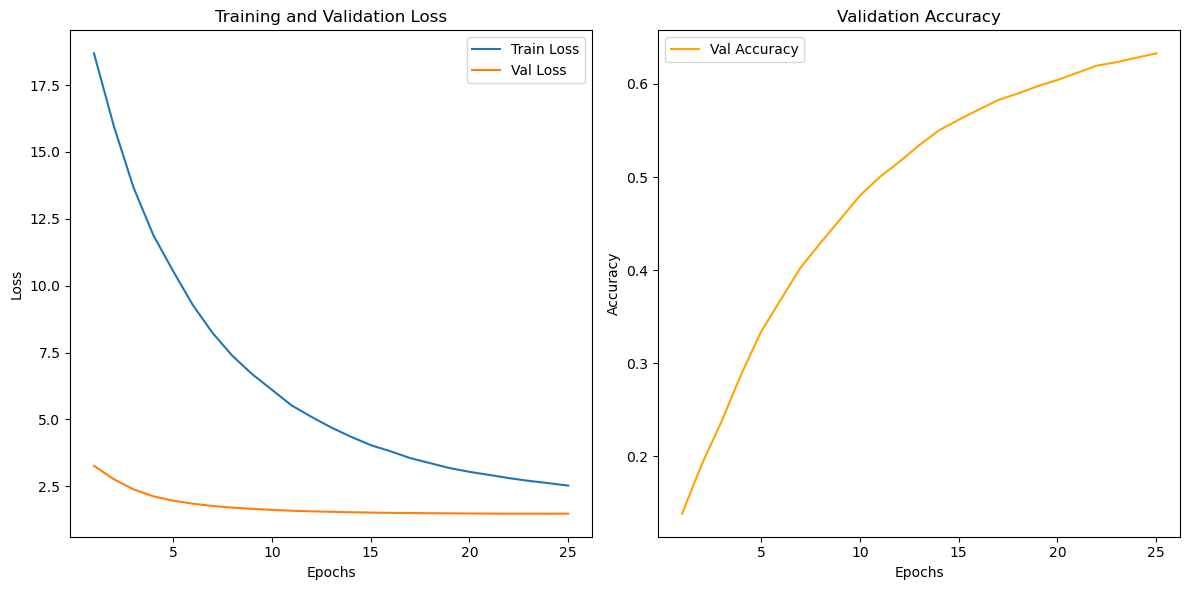

学习率：0.1 正则化强度0.01
Epoch 5: Train Loss: 1.0682 | Val Loss: 1.1162 | Val Accuracy: 0.6497
Epoch 10: Train Loss: 0.9463 | Val Loss: 0.9338 | Val Accuracy: 0.7213
Epoch 15: Train Loss: 0.8117 | Val Loss: 0.8507 | Val Accuracy: 0.7428
Epoch 20: Train Loss: 0.8141 | Val Loss: 0.8084 | Val Accuracy: 0.7654
Epoch 25: Train Loss: 0.7367 | Val Loss: 0.7697 | Val Accuracy: 0.7767


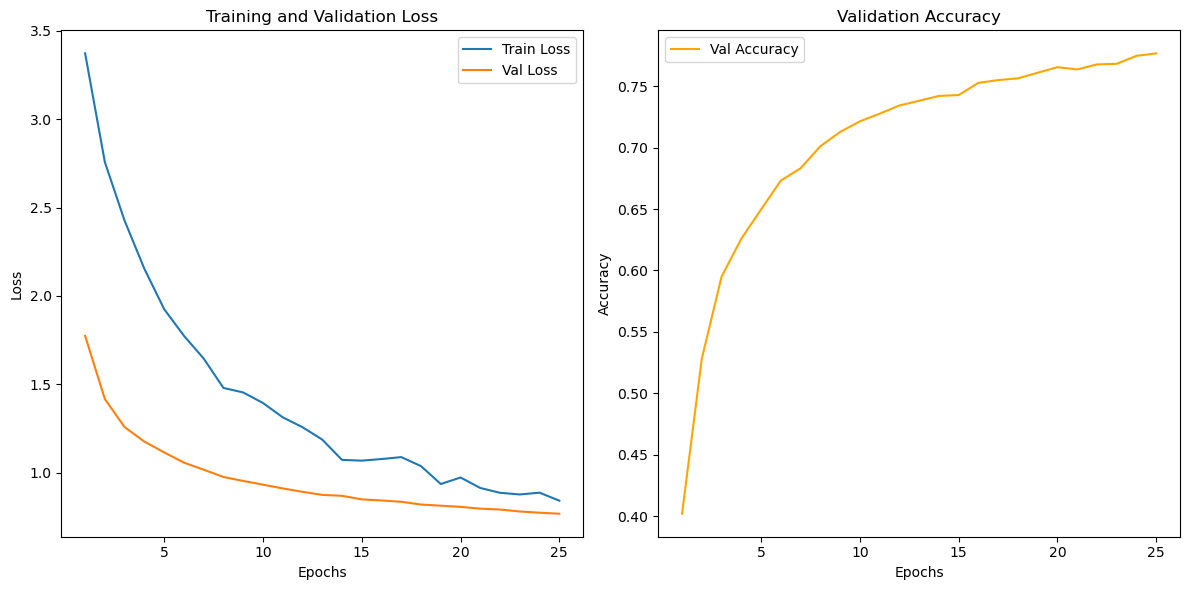

学习率：0.1 正则化强度0.1
Epoch 5: Train Loss: 1.5500 | Val Loss: 1.5826 | Val Accuracy: 0.5356
Epoch 10: Train Loss: 1.5109 | Val Loss: 1.4926 | Val Accuracy: 0.5490
Epoch 15: Train Loss: 1.4845 | Val Loss: 1.4974 | Val Accuracy: 0.4613
Epoch 20: Train Loss: 1.5571 | Val Loss: 1.5449 | Val Accuracy: 0.4748
Epoch 25: Train Loss: 1.5862 | Val Loss: 1.5540 | Val Accuracy: 0.4718


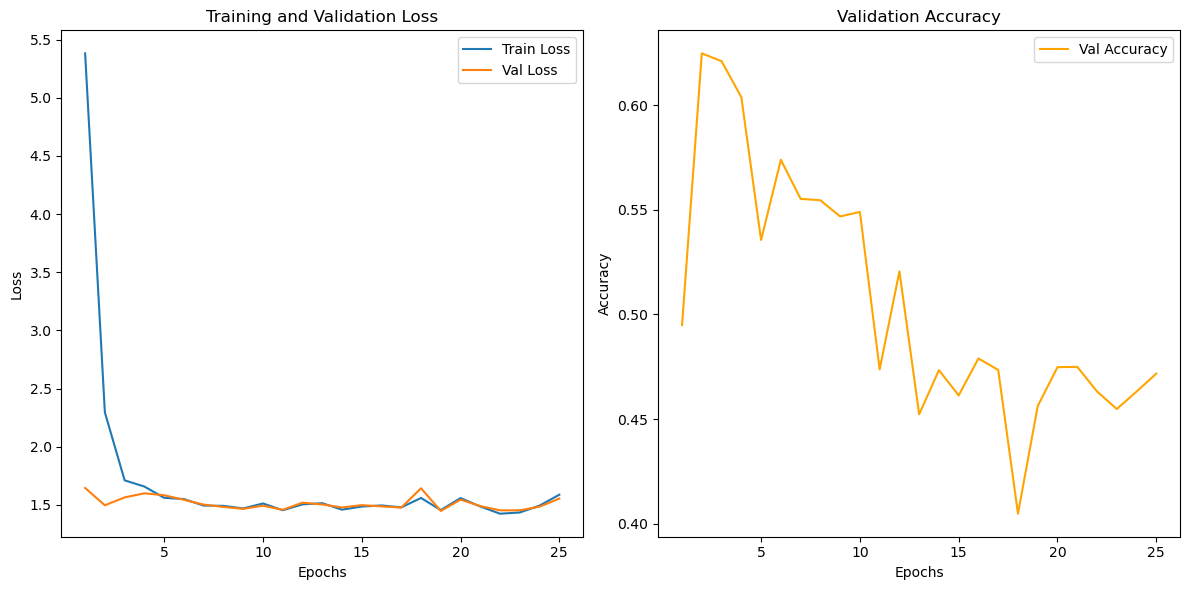

隐藏层大小为：(512, 128)
学习率：0.01 正则化强度0.01
Epoch 5: Train Loss: 2.3931 | Val Loss: 2.4237 | Val Accuracy: 0.3573
Epoch 10: Train Loss: 1.8356 | Val Loss: 1.8471 | Val Accuracy: 0.4725
Epoch 15: Train Loss: 1.4978 | Val Loss: 1.6287 | Val Accuracy: 0.5258
Epoch 20: Train Loss: 1.5162 | Val Loss: 1.4968 | Val Accuracy: 0.5513
Epoch 25: Train Loss: 1.4530 | Val Loss: 1.4241 | Val Accuracy: 0.5719


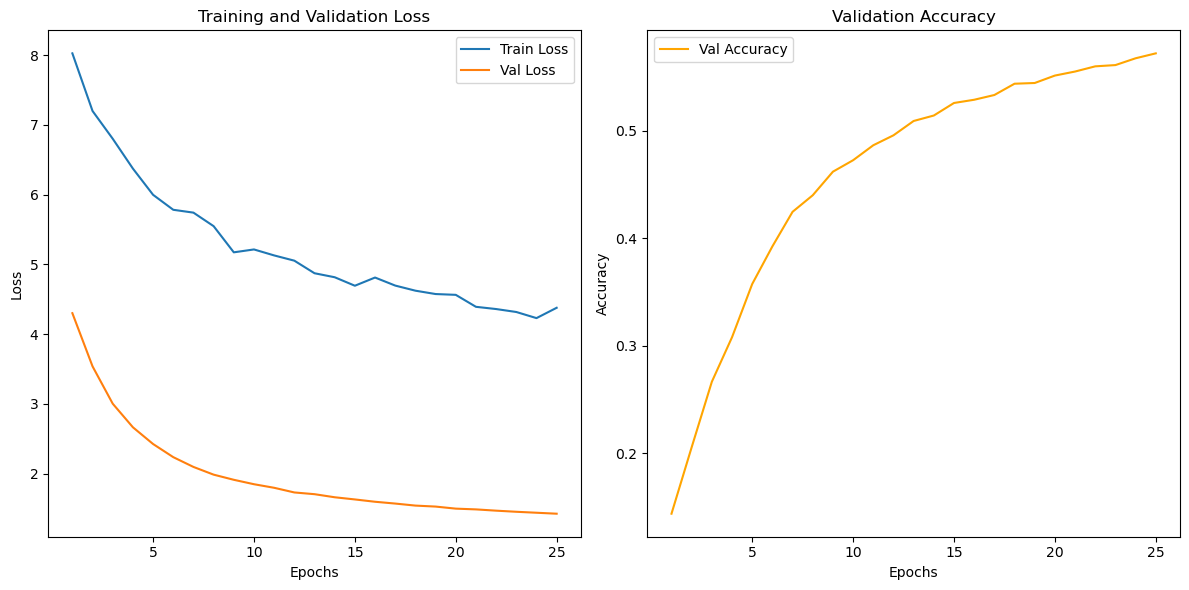

学习率：0.01 正则化强度0.1
Epoch 5: Train Loss: 1.9029 | Val Loss: 1.9373 | Val Accuracy: 0.3915
Epoch 10: Train Loss: 1.4829 | Val Loss: 1.4138 | Val Accuracy: 0.5417
Epoch 15: Train Loss: 1.2514 | Val Loss: 1.2510 | Val Accuracy: 0.6232
Epoch 20: Train Loss: 1.2353 | Val Loss: 1.2109 | Val Accuracy: 0.6583
Epoch 25: Train Loss: 1.1823 | Val Loss: 1.2072 | Val Accuracy: 0.6842


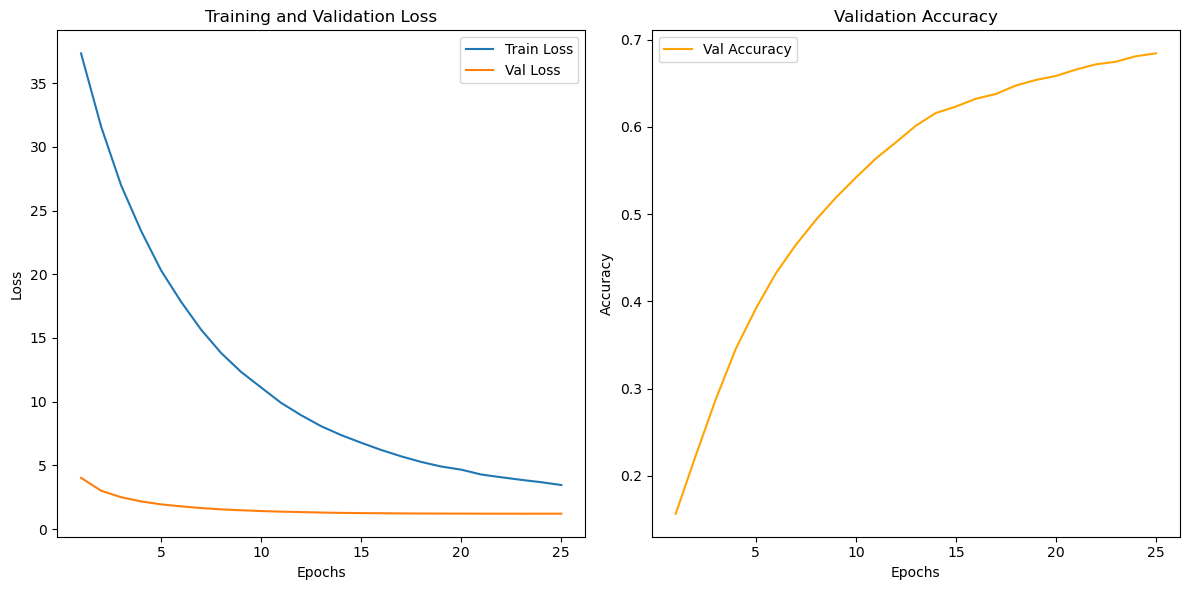

学习率：0.1 正则化强度0.01
Epoch 5: Train Loss: 0.9881 | Val Loss: 0.9663 | Val Accuracy: 0.6926
Epoch 10: Train Loss: 0.7365 | Val Loss: 0.8061 | Val Accuracy: 0.7510
Epoch 15: Train Loss: 0.7554 | Val Loss: 0.7415 | Val Accuracy: 0.7719
Epoch 20: Train Loss: 0.6882 | Val Loss: 0.7017 | Val Accuracy: 0.7877
Epoch 25: Train Loss: 0.5993 | Val Loss: 0.6697 | Val Accuracy: 0.7977


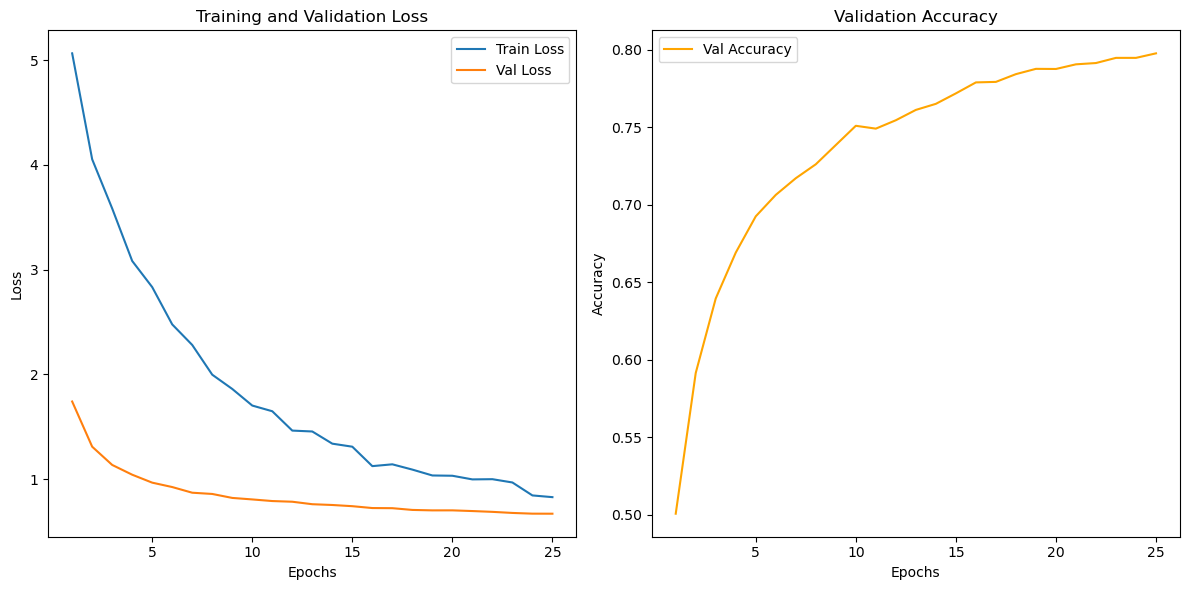

学习率：0.1 正则化强度0.1
Epoch 5: Train Loss: 1.3163 | Val Loss: 1.3389 | Val Accuracy: 0.6494
Epoch 10: Train Loss: 1.2486 | Val Loss: 1.2165 | Val Accuracy: 0.6406
Epoch 15: Train Loss: 1.1526 | Val Loss: 1.1859 | Val Accuracy: 0.6743
Epoch 20: Train Loss: 1.1196 | Val Loss: 1.1410 | Val Accuracy: 0.6847
Epoch 25: Train Loss: 1.2176 | Val Loss: 1.2343 | Val Accuracy: 0.6827


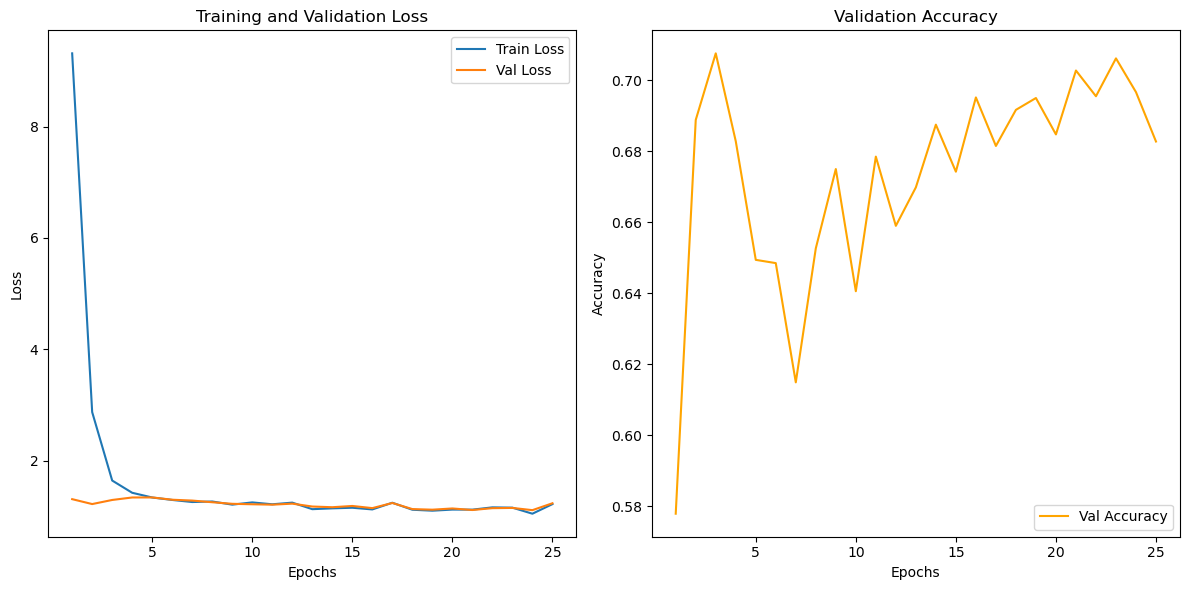

隐藏层大小为：(600, 300)
学习率：0.01 正则化强度0.01
Epoch 5: Train Loss: 2.7248 | Val Loss: 2.7109 | Val Accuracy: 0.4407
Epoch 10: Train Loss: 1.7715 | Val Loss: 2.0288 | Val Accuracy: 0.5484
Epoch 15: Train Loss: 1.7021 | Val Loss: 1.7714 | Val Accuracy: 0.5905
Epoch 20: Train Loss: 1.5682 | Val Loss: 1.6277 | Val Accuracy: 0.6151
Epoch 25: Train Loss: 1.5104 | Val Loss: 1.5149 | Val Accuracy: 0.6297


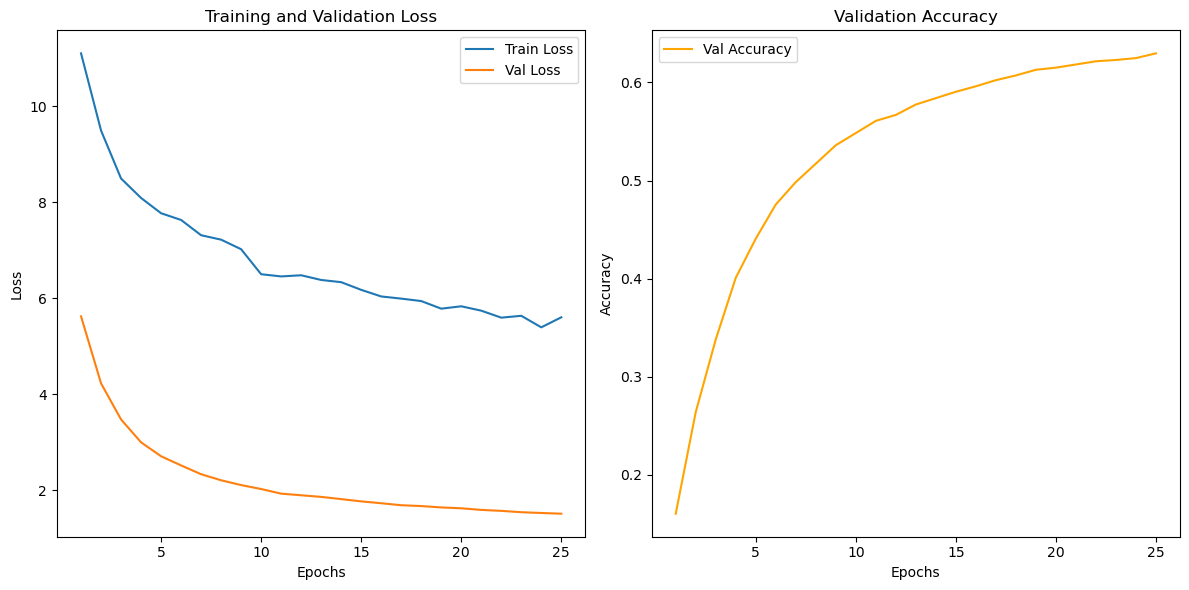

学习率：0.01 正则化强度0.1
Epoch 5: Train Loss: 1.9195 | Val Loss: 2.0269 | Val Accuracy: 0.4677
Epoch 10: Train Loss: 1.1657 | Val Loss: 1.3004 | Val Accuracy: 0.6028
Epoch 15: Train Loss: 1.0045 | Val Loss: 1.0916 | Val Accuracy: 0.6598
Epoch 20: Train Loss: 1.0197 | Val Loss: 1.0148 | Val Accuracy: 0.6920
Epoch 25: Train Loss: 1.0005 | Val Loss: 0.9971 | Val Accuracy: 0.7147


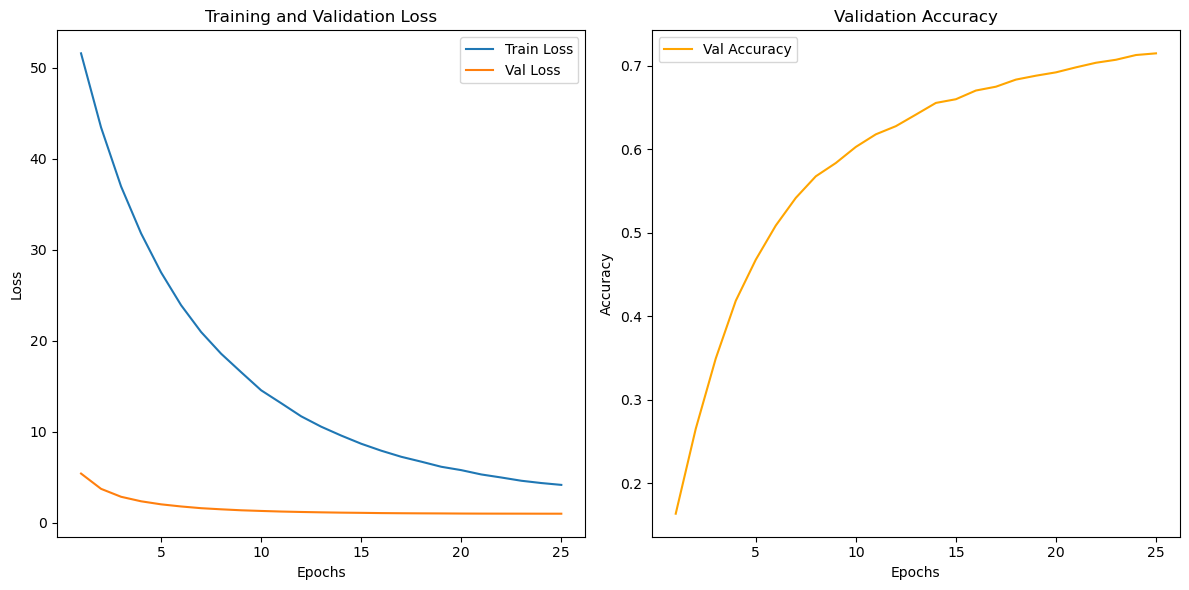

学习率：0.1 正则化强度0.01
Epoch 5: Train Loss: 0.9655 | Val Loss: 0.9400 | Val Accuracy: 0.7174
Epoch 10: Train Loss: 0.7162 | Val Loss: 0.7336 | Val Accuracy: 0.7662
Epoch 15: Train Loss: 0.5883 | Val Loss: 0.6727 | Val Accuracy: 0.7867
Epoch 20: Train Loss: 0.6121 | Val Loss: 0.6332 | Val Accuracy: 0.8018
Epoch 25: Train Loss: 0.5899 | Val Loss: 0.6118 | Val Accuracy: 0.8135


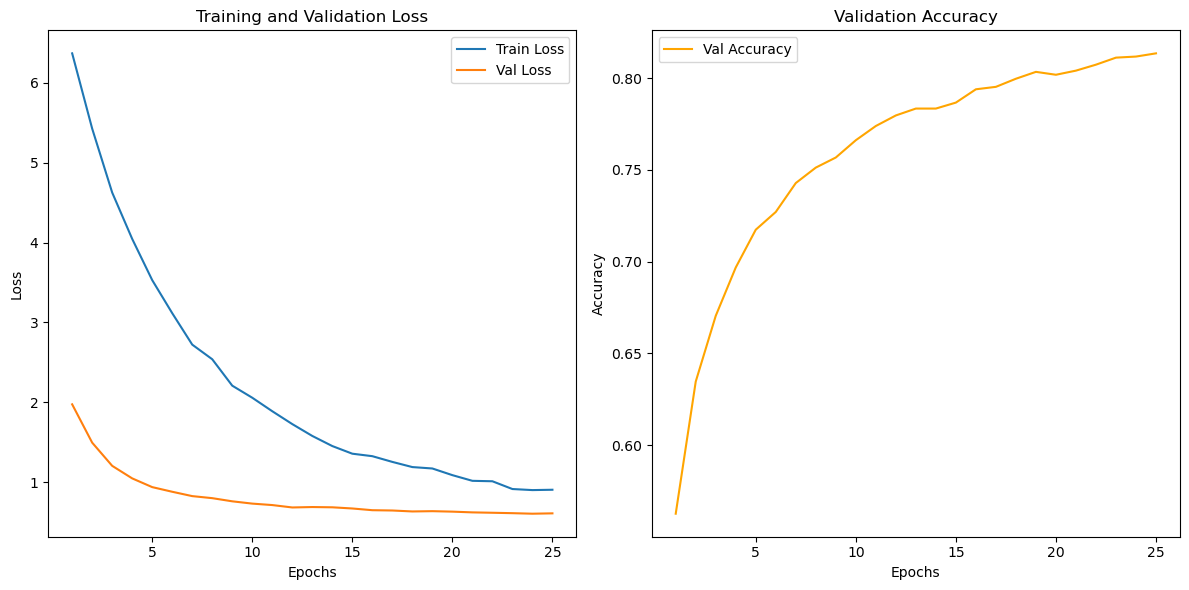

学习率：0.1 正则化强度0.1
Epoch 5: Train Loss: 1.1714 | Val Loss: 1.2002 | Val Accuracy: 0.6797
Epoch 10: Train Loss: 1.0614 | Val Loss: 1.0915 | Val Accuracy: 0.7299
Epoch 15: Train Loss: 1.0645 | Val Loss: 1.1076 | Val Accuracy: 0.7021
Epoch 20: Train Loss: 1.0255 | Val Loss: 1.0401 | Val Accuracy: 0.7288
Epoch 25: Train Loss: 1.0065 | Val Loss: 1.0052 | Val Accuracy: 0.7369


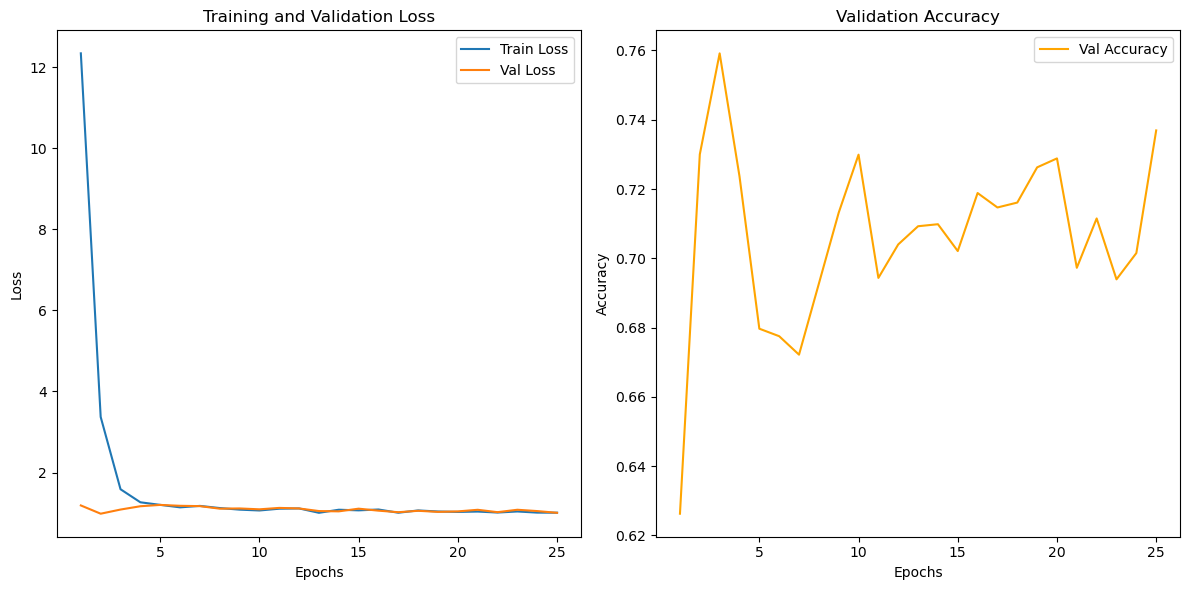

In [142]:
#在数据集上训练模型
import mnist_reader
import matplotlib.pyplot as plt

# 加载Fashion-MNIST数据集
X_train, y_train = mnist_reader.load_mnist('C:/Users/bwr/Desktop/研一下/机器学习和深度学习/fashion-mnist-master/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('C:/Users/bwr/Desktop/研一下/机器学习和深度学习/fashion-mnist-master/data/fashion', kind='t10k')
from sklearn.model_selection import train_test_split

# 将数据集划分为训练集和验证集，test_size 参数指定验证集比例
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
num_classes = 10

# 将标签进行one-hot编码
y_train_onehot = np.eye(num_classes)[y_train]
y_val_onehot = np.eye(num_classes)[y_val]
y_test_onehot = np.eye(num_classes)[y_test]

hyperparam,accuracy,weight=grid_search(X_train, y_train_onehot, X_val, y_val_onehot, 784, 10, 25, [0.01,0.1], [0.01,0.1], [(256,64),(512,128),(600,300)],sigmoid)

### 网络最优参数可视化

In [143]:
print(hyperparam,accuracy,weight)

{'hidden_size_1': 600, 'hidden_size_2': 300, 'lr': 0.1, 'lambda_reg': 0.01} 0.8135 {'W1': array([[ 0.20261216,  0.13110181, -0.22564644, ...,  0.06471761,
        -0.01983655,  0.30948791],
       [-0.4153731 ,  0.18878166, -0.03178954, ..., -0.09965211,
        -0.09206286,  0.01779758],
       [-0.73697939,  0.09027933,  0.10756064, ..., -0.14108694,
         0.10437638, -0.12483004],
       ...,
       [-0.26485276,  0.06743949,  0.10670936, ...,  0.03633092,
        -0.0273645 , -0.01865794],
       [-0.17996432, -0.51373995,  0.24450788, ...,  0.25061538,
         0.21317679, -0.07596126],
       [ 0.31205425, -0.27025943, -0.16870874, ..., -0.37668756,
         0.11862568,  0.02725908]]), 'b1': array([[ 2.89986195e-04,  1.91513364e-04, -5.52258779e-04,
         2.50330039e-04,  2.83926861e-05,  1.60655007e-04,
         2.80408454e-04,  1.26257897e-05, -2.09891083e-04,
         1.27561408e-04,  2.85274808e-06,  2.78753447e-04,
        -1.55939845e-04,  3.49993706e-04, -1.98279633e

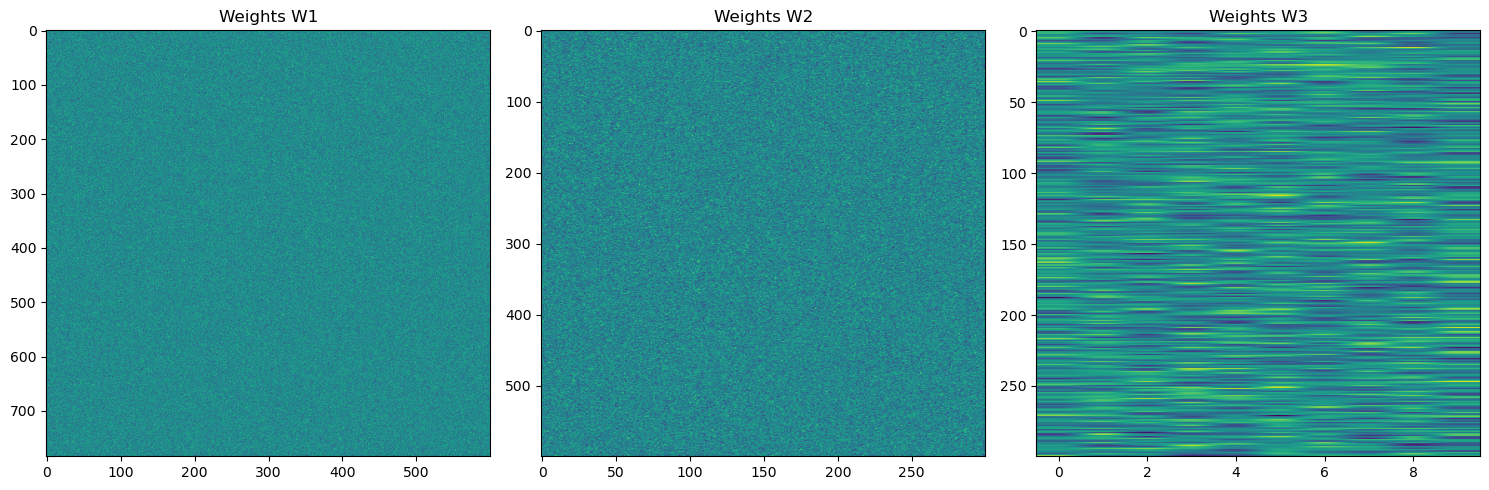

In [144]:
### 已训练好的模型参数可视化
def visualize_weights(weights):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(weights['W1'], cmap='viridis', aspect='auto')
    axs[0].set_title('Weights W1')

    axs[1].imshow(weights['W2'], cmap='viridis', aspect='auto')
    axs[1].set_title('Weights W2')

    axs[2].imshow(weights['W3'], cmap='viridis', aspect='auto')
    axs[2].set_title('Weights W3')

    plt.tight_layout()
    plt.show()

# Assuming you have `best_weights` dictionary containing the best weights
visualize_weights(weight)


### 测试部分

In [145]:
def test(test_set, y_test_set, best_weights):
    nn = NeuralNetwork(best_weights['W1'].shape[0], best_weights['W1'].shape[1], best_weights['W2'].shape[1],best_weights['W3'].shape[1],0.1,sigmoid)
    nn.W1 = best_weights['W1']
    nn.b1 = best_weights['b1']
    nn.W2 = best_weights['W2']
    nn.b2 = best_weights['b2']
    nn.W3 = best_weights['W3']
    nn.b3 = best_weights['b3']

    y_pred_test = nn.forward(test_set)
    test_accuracy = np.mean(np.argmax(y_test_set, axis=1) == np.argmax(y_pred_test, axis=1))
    print(f"Test Accuracy: {test_accuracy:.4f}")
test(X_test,y_test_onehot,weight)

Test Accuracy: 0.8024


C:\Users\bwr\AppData\Local\Temp\ipykernel_39244\3079578162.py:75: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
